In [4]:
import os
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode')
import numpy as np
import core
import pylab as plt
import nibabel as nib
from skimage import filters
from scipy import ndimage

planes = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/planes-params.npy')
pixelspacing = []
path = '/Users/fair00542/Desktop/TestImages/ScanE/1.3.12.2.1107.5.1.4.95198.30000015061008243097400047435.dcm'
if path.endswith('.dcm'):
    array, ConstPixelSpacing, origin, path, affine = core.dicom2np(path)
    #bone = core.thresholdnp(array, 900, 1500)
    #softtissue  = core.thresholdnp(array, 0, 80)
    pixelspacing.append(ConstPixelSpacing)

#threshold, get-rid of outliars
tarray = np.multiply(array, (array>-1024).astype(int))
tarray = np.multiply(tarray, (tarray<3071).astype(int))
array1 = np.multiply(tarray, (tarray>0.0).astype(int))

#skull
skull_mask = (array1>100.0).astype(int) #boolea

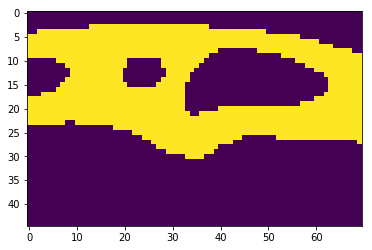

In [5]:
# Currently the region of interest is set manually, however, it could be done by extractin a 
# rectangular searching box around the mid plane where it intersects with the bone
im = skull_mask[:,:,141]
ROI = im[45:90,220:290]
plt.imshow(ROI)
plt.show()

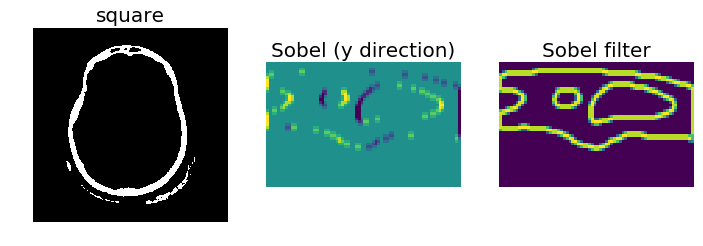

In [6]:
sx = ndimage.sobel(ROI, axis=0, mode='constant')
sy = ndimage.sobel(ROI, axis=1, mode='constant')
sob = np.hypot(sx, sy)

plt.figure(figsize=(16, 5))
plt.subplot(141)
plt.imshow(im, cmap=plt.cm.gray)
plt.axis('off')
plt.title('square', fontsize=20)
plt.subplot(142)
plt.imshow(sy)
plt.axis('off')
plt.title('Sobel (y direction)', fontsize=20)
plt.subplot(143)
plt.imshow(sob)
plt.axis('off')
plt.title('Sobel filter', fontsize=20)
plt.show()

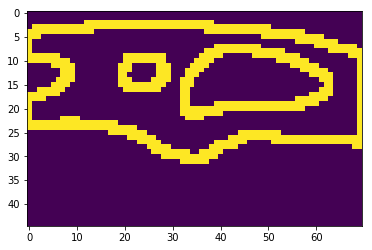

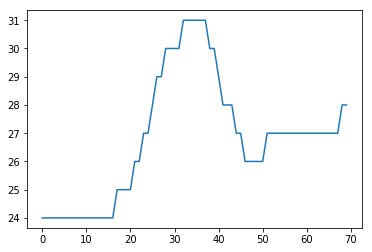

In [7]:
edge_mask = (sob>0.0).astype(int)
plt.imshow(edge_mask)
plt.show()

# Extracting the curve of the interior bone edge
y = []
x = []
for i in range(edge_mask.shape[1]):
    y.append(np.nonzero(edge_mask[:,i])[0][-1])
    x.append(i)

from matplotlib import pyplot
pyplot.plot(x,y)
pyplot.show()

<IPython.core.display.Javascript object>


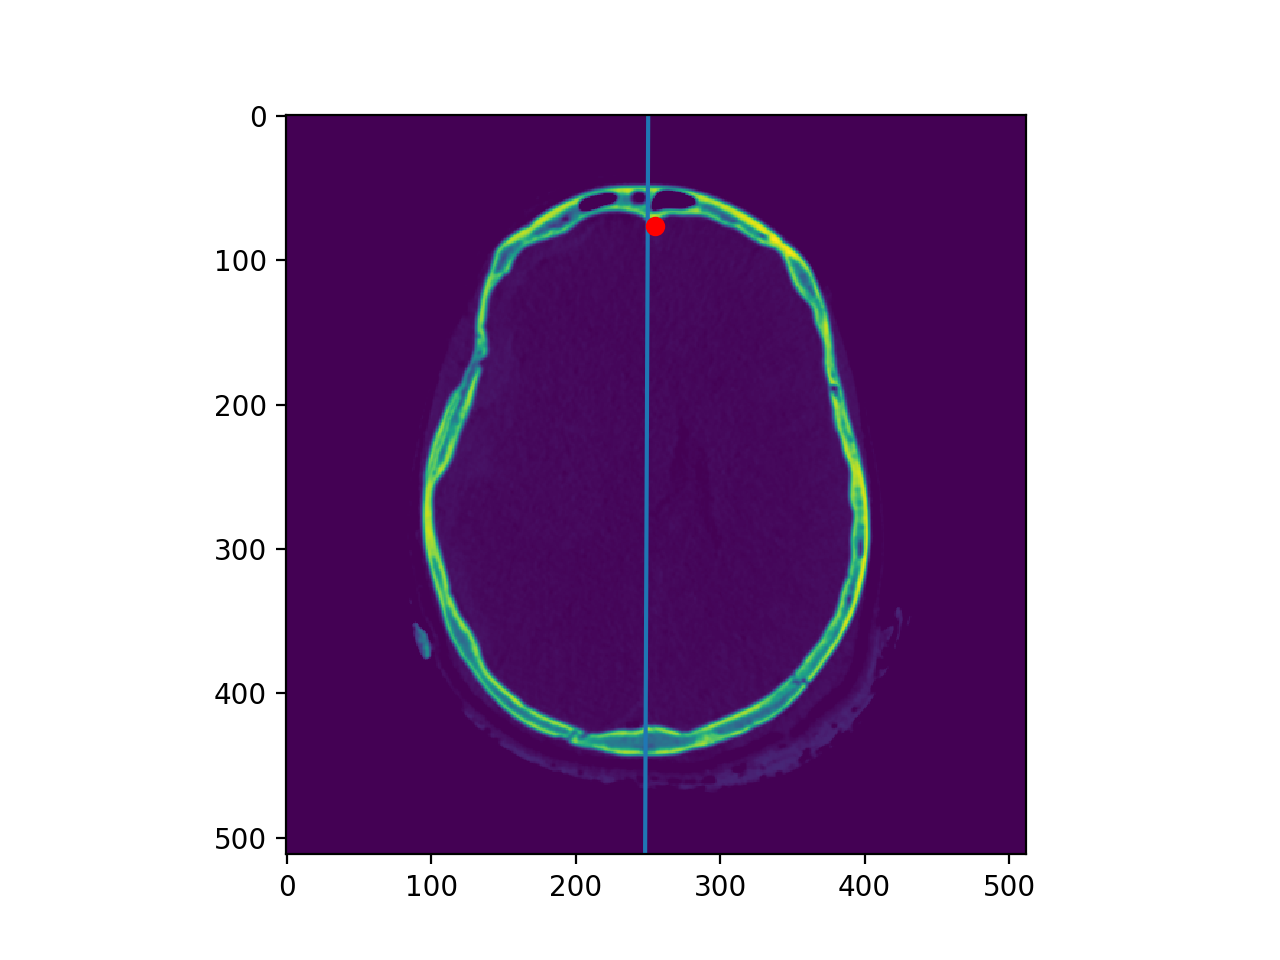

In [8]:
protrusion_point = (220 + np.median(np.where(y==np.max(y))),45 + np.max(y))
protrusion_point

# Upload midplane
plane = planes[3]
a,b,c,d = plane[1:].astype(np.float64)

# Plot original midplane
i = 141

% matplotlib nbagg
x_midplane = np.linspace(0,array[:,:,i].shape[0], 2)
y_midplane = (d-c*i-a*x_midplane)/b
plt.plot(x_midplane,y_midplane, )
plt.plot([protrusion_point[0]],[protrusion_point[1]],'ro')
plt.imshow(array1[:,:,i])
plt.ion()

<IPython.core.display.Javascript object>


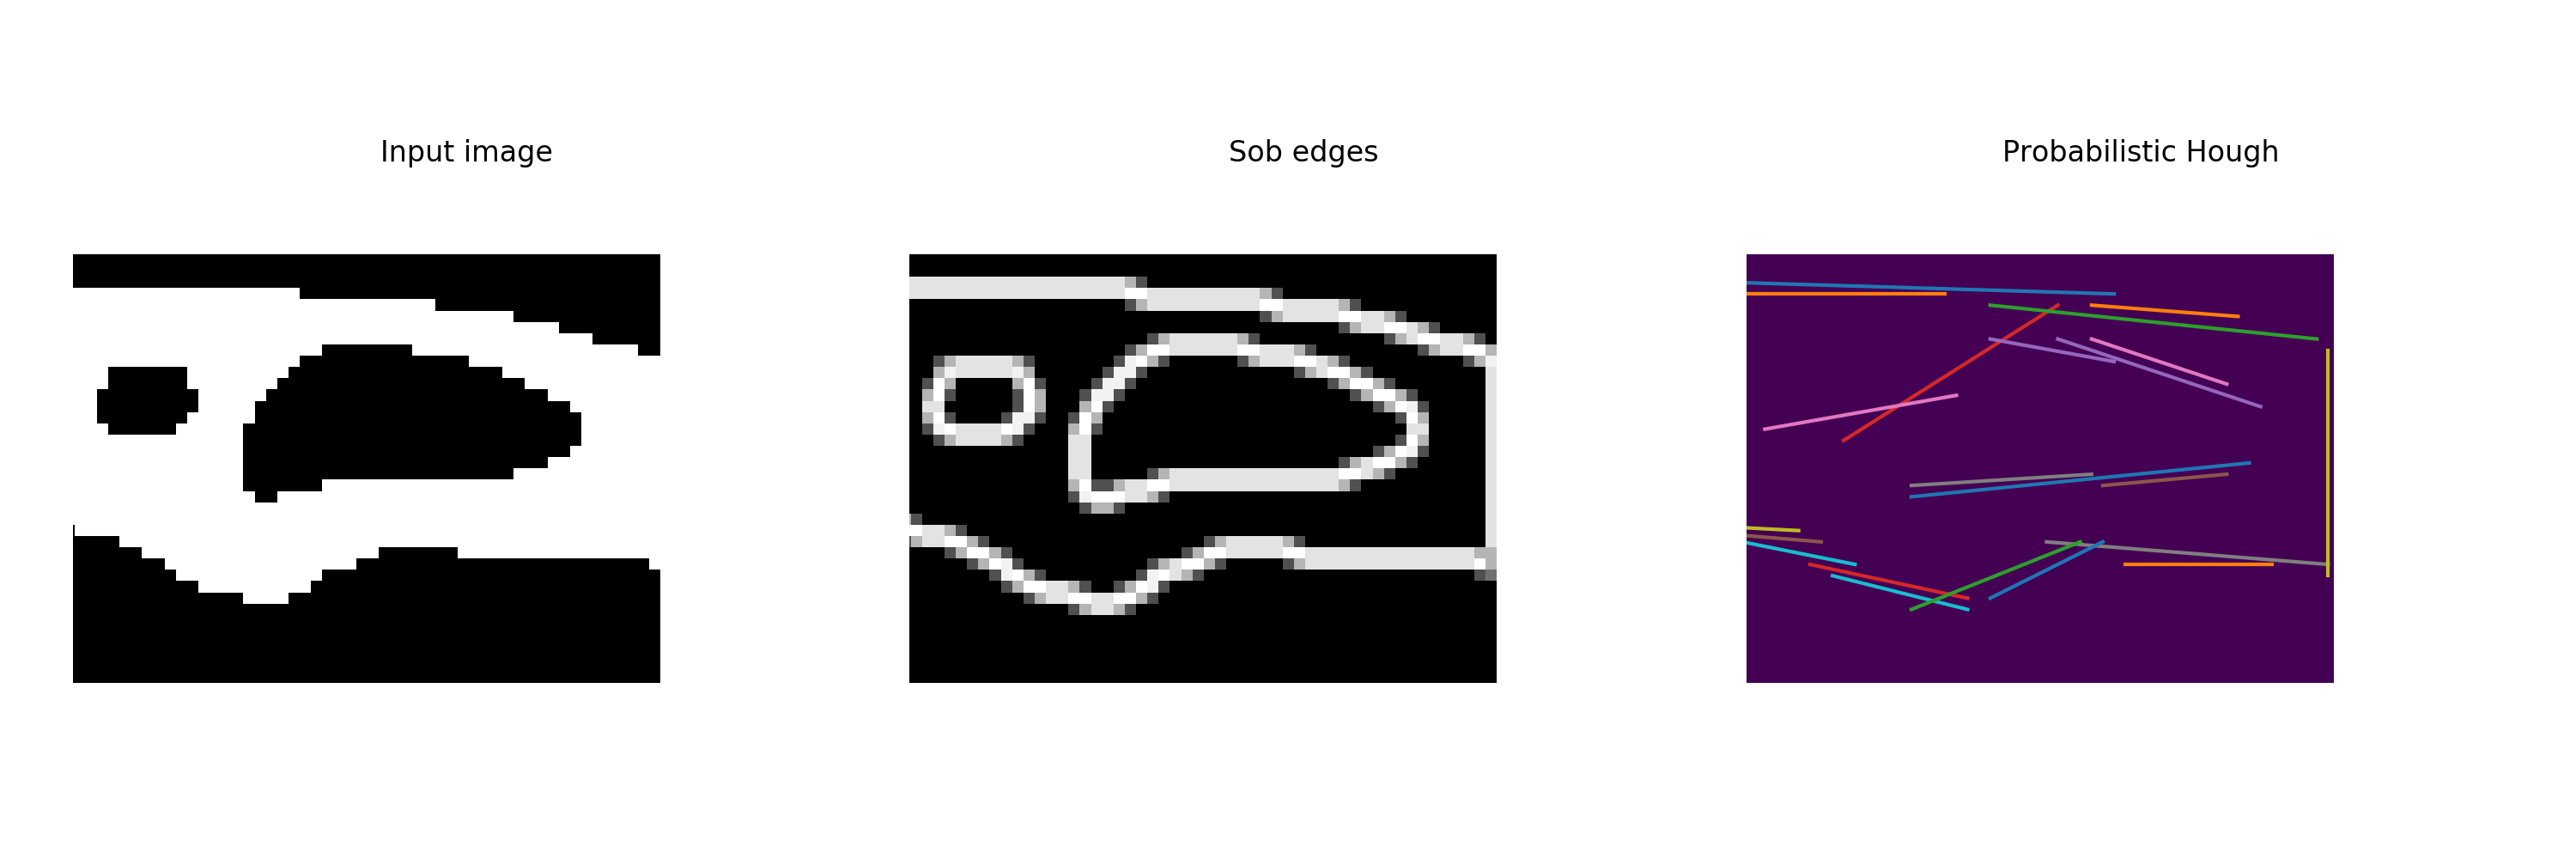

In [10]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
import matplotlib.pyplot as plt
from matplotlib import cm

# Line finding using the Probabilistic Hough Transform
# Return lines with starts and end coordinates
# Increase line_length to get rid of shorter lines
image = ROI
edges = sob
lines = probabilistic_hough_line(edges, threshold=10, line_length=10,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Sob edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()
    a.set_adjustable('box-forced')

plt.tight_layout()
plt.show()
